In [1]:
#import packages
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import cinemaot as co
from anndata import AnnData

/opt/homebrew/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/opt/homebrew/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/guardian/Desktop/CINEMA-OT/cinemaot/benchmark.py:15: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
#Functions for evaluation
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

def preprocessing(i):
    adata = sc.read_h5ad('SplatterBenchmarkData4/adata'+str(i-1)+'.h5ad')
    adata.var_names_make_unique()
    adata.obs.rename(columns={"Groups": "groups", "group": "states","program_usage": "steps"}, inplace=True)
    adata.obs['groups'] = adata.obs['groups'].astype(str)
    adata.obs['states'] = adata.obs['states'].astype(str)
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    return adata

def groundtruth(adata,i):
    adata1 = adata[adata.obs['groups']=='1',:]
    adata2 = adata[adata.obs['groups']=='2',:]
    
    gtmatrix = np.zeros([adata2.X.shape[0],adata1.X.shape[0]])
    gtmatrix2 = np.zeros([adata2.X.shape[0],adata1.X.shape[0]])
    states1 = adata.obs['states'].values[adata.obs['groups']=='1']
    states2 = adata.obs['states'].values[adata.obs['groups']=='2']

    steps1 = adata1.obs['steps'].values
    steps2 = adata2.obs['steps'].values
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(steps1.reshape(-1, 1))
    gtmatrix = nbrs.kneighbors_graph(steps2.reshape(-1, 1)).toarray()

    
    s2 = adata.obs['groups']=='2'
    s1 = adata.obs['groups']=='1'
    #te2 = np.mean(gtdata[:,s2.values],axis=1) - np.mean(gtdata[:,s1.values],axis=1)
    #te2 = np.repeat(te2[:,None],round(np.sum(s2.values)),axis=1).T
    te2 = adata.X[adata.obs['groups']=='2',:] - np.mean(adata.X[adata.obs['groups']=='1',:],axis=0)
    return gtmatrix, te2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
#Evaluation of mixscape
auc_mixscape = np.zeros(15)
corr_mixscape = np.zeros(15)
scorr_mixscape = np.zeros(15)

for i in range(1,16):
    adata = preprocessing(i)
    gtmatching, gite = groundtruth(adata,i)
    signal, matching, ite = co.benchmark.mixscape(adata,'groups','2','1')
    auc_mixscape[i-1], corr_mixscape[i-1],scorr_mixscape[i-1] = co.benchmark.evaluate_cinema(matching,ite,gtmatching,gite)
    #auc_mixscape.append(auc_mixscape_)
    #corr_mixscape.append(corr_mixscape_)
    #scorr_mixscape.append(scorr_mixscape_)
    if i == 1:
        metrics_mixscape = co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True],graph_conn=False)
    else:
        metrics_mixscape = pd.concat([metrics_mixscape,co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True],graph_conn=False)], axis = 1)
    if i == 1:
        metrics_mixscape2 = co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True],graph_conn=False)
    else:
        metrics_mixscape2 = pd.concat([metrics_mixscape2,co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True],graph_conn=False)], axis = 1)
        
metrics_mixscape.columns = np.arange(15)

Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW

In [5]:
auc_harmony = np.zeros(15)
corr_harmony = np.zeros(15)
scorr_harmony = np.zeros(15)

for i in range(1,16):
    adata = preprocessing(i)
    gtmatching, gite = groundtruth(adata,i)
    signal, matching, ite = co.benchmark.harmony_mixscape(adata,'groups','2','1')
    auc_harmony[i-1], corr_harmony[i-1],scorr_harmony[i-1] = co.benchmark.evaluate_cinema(matching,ite,gtmatching,gite)
    #auc_harmony.append(auc_harmony_)
    #corr_harmony.append(corr_harmony_)
    #scorr_harmony.append(scorr_harmony_)
    if i == 1:
        metrics_harmony = co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True],graph_conn=False)
    else:
        metrics_harmony = pd.concat([metrics_harmony,co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True],graph_conn=False)], axis = 1)
    if i == 1:
        metrics_harmony2 = co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True],graph_conn=False)
    else:
        metrics_harmony2 = pd.concat([metrics_harmony2,co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True],graph_conn=False)], axis = 1)
        
metrics_harmony.columns = np.arange(15)

2022-07-12 23:52:05,948 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:06,064 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:06,125 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:06,178 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


2022-07-12 23:52:08,684 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:08,763 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:08,830 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:08,908 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


2022-07-12 23:52:11,150 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:11,225 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:11,282 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:11,347 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


2022-07-12 23:52:13,705 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:13,790 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:13,853 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:13,934 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


2022-07-12 23:52:16,705 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:16,781 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:16,853 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:16,929 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


2022-07-12 23:52:19,920 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:20,013 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:20,098 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:20,185 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


2022-07-12 23:52:22,865 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:22,937 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:23,016 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:23,103 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


2022-07-12 23:52:25,480 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:25,555 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:25,642 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:25,720 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


2022-07-12 23:52:28,370 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:28,450 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:28,521 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:28,594 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


2022-07-12 23:52:31,024 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:31,086 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:31,176 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:31,266 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


2022-07-12 23:52:33,885 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:33,960 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:34,063 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:34,146 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


2022-07-12 23:52:37,019 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:37,095 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:37,195 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:37,290 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


2022-07-12 23:52:39,799 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:39,870 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:39,938 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:40,006 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


2022-07-12 23:52:42,569 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:42,632 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:42,704 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:42,795 - harmonypy - INFO - Converged after 3 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


2022-07-12 23:52:45,371 - harmonypy - INFO - Iteration 1 of 10
2022-07-12 23:52:45,452 - harmonypy - INFO - Iteration 2 of 10
2022-07-12 23:52:45,529 - harmonypy - INFO - Iteration 3 of 10
2022-07-12 23:52:45,607 - harmonypy - INFO - Iteration 4 of 10
2022-07-12 23:52:45,687 - harmonypy - INFO - Converged after 4 iterations


Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...


In [6]:
auc_OT = np.zeros(15)
corr_OT = np.zeros(15)
scorr_OT = np.zeros(15)

for i in range(1,16):
    adata = preprocessing(i)
    gtmatching, gite = groundtruth(adata,i)
    signal, matching, ite = co.benchmark.OT(adata,'groups','2','1',thres=0.2)
    auc_OT[i-1], corr_OT[i-1], scorr_OT[i-1] = co.benchmark.evaluate_cinema(matching,ite,gtmatching,gite)
    #auc_OT.append(auc_OT_)
    #corr_OT.append(corr_OT_)
    #scorr_OT.append(scorr_OT_)
    if i == 1:
        metrics_OT = co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True],graph_conn=False)
    else:
        metrics_OT = pd.concat([metrics_OT,co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True],graph_conn=False)], axis = 1)
    if i == 1:
        metrics_OT2 = co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True],graph_conn=False)
    else:
        metrics_OT2 = pd.concat([metrics_OT2,co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True],graph_conn=False)], axis = 1)
        
metrics_OT.columns = np.arange(15)

Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score

In [7]:
auc_cinemaot = np.zeros(15)
corr_cinemaot = np.zeros(15)
scorr_cinemaot = np.zeros(15)

for i in range(1,16):
    adata = preprocessing(i)
    gtmatching, gite = groundtruth(adata,i)
    signal, matching, ite = co.cinemaot.cinemaot_unweighted(adata,obs_label='groups', ref_label='2', expr_label='1',mode='parametric',dim=None,thres=0.5,eps=1e-3,smoothness=5e-4)
    auc_cinemaot[i-1], corr_cinemaot[i-1],scorr_cinemaot[i-1] = co.benchmark.evaluate_cinema(matching,ite,gtmatching,gite)
    #auc_cinemaot.append(auc_cinemaot_)
    #corr_cinemaot.append(corr_cinemaot_)
    #scorr_cinemaot.append(scorr_cinemaot_)
    if i == 1:
        metrics_cinemaot = co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True],graph_conn=False)
    else:
        metrics_cinemaot = pd.concat([metrics_cinemaot,co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True],graph_conn=False)], axis = 1)
    if i == 1:
        metrics_cinemaot2 = co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True],graph_conn=False)
    else:
        metrics_cinemaot2 = pd.concat([metrics_cinemaot2,co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True],graph_conn=False)], axis = 1)
        
metrics_cinemaot.columns = np.arange(15)

Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Iso

In [8]:
auc_wcinemaot = np.zeros(15)
corr_wcinemaot = np.zeros(15)
scorr_wcinemaot = np.zeros(15)

for i in range(1,16):
    adata = preprocessing(i)
    gtmatching, gite = groundtruth(adata,i)
    signal, matching, ite, r, c = co.cinemaot.cinemaot_weighted(adata,obs_label='groups', ref_label='2', expr_label='1',mode='parametric',dim=None,thres=0.85,eps=1e-3)
    auc_wcinemaot[i-1], corr_wcinemaot[i-1],scorr_wcinemaot[i-1] = co.benchmark.evaluate_cinema(matching,ite,gtmatching,gite)
    #auc_wcinemaot.append(auc_wcinemaot_)
    #corr_wcinemaot.append(corr_wcinemaot_)
    #scorr_wcinemaot.append(scorr_wcinemaot_)
    if i == 1:
        metrics_wcinemaot = co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True],graph_conn=False)
    else:
        metrics_wcinemaot = pd.concat([metrics_wcinemaot,co.benchmark.evaluate_batch(signal,adata,'groups',['states','steps'],[False,True],graph_conn=False)], axis = 1)
    if i == 1:
        metrics_wcinemaot2 = co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True],graph_conn=False)
    else:
        metrics_wcinemaot2 = pd.concat([metrics_wcinemaot2,co.benchmark.evaluate_batch(signal,adata,'states',['groups','steps'],[False,True],graph_conn=False)], axis = 1)
        
metrics_wcinemaot.columns = np.arange(15)

Building graph on 1000 samples and 28 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.03 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.05 seconds.
Building graph on 3000 samples and 28 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.22 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.28 seconds.
Building graph on 1000 samples and 28 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.04 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.09 seconds.
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Building graph on 1000 samples and 32 features.
Calculating 

  Calculating KNN search...
  Calculated KNN search in 0.04 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.10 seconds.
Silhouette score...
PC regression...
Isolated labels ASW...
Silhouette score...
PC regression...
Isolated labels ASW...
Building graph on 1000 samples and 41 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.05 seconds.
  Calculating affinities...
  Calculated affinities in 0.01 seconds.
Calculated graph and diffusion operator in 0.09 seconds.
Building graph on 3000 samples and 41 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.26 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
Calculated graph and diffusion operator in 0.33 seconds.
Building graph on 1000 samples and 41 features.
Calculating graph and diffusion operator...
  Calculating KNN s

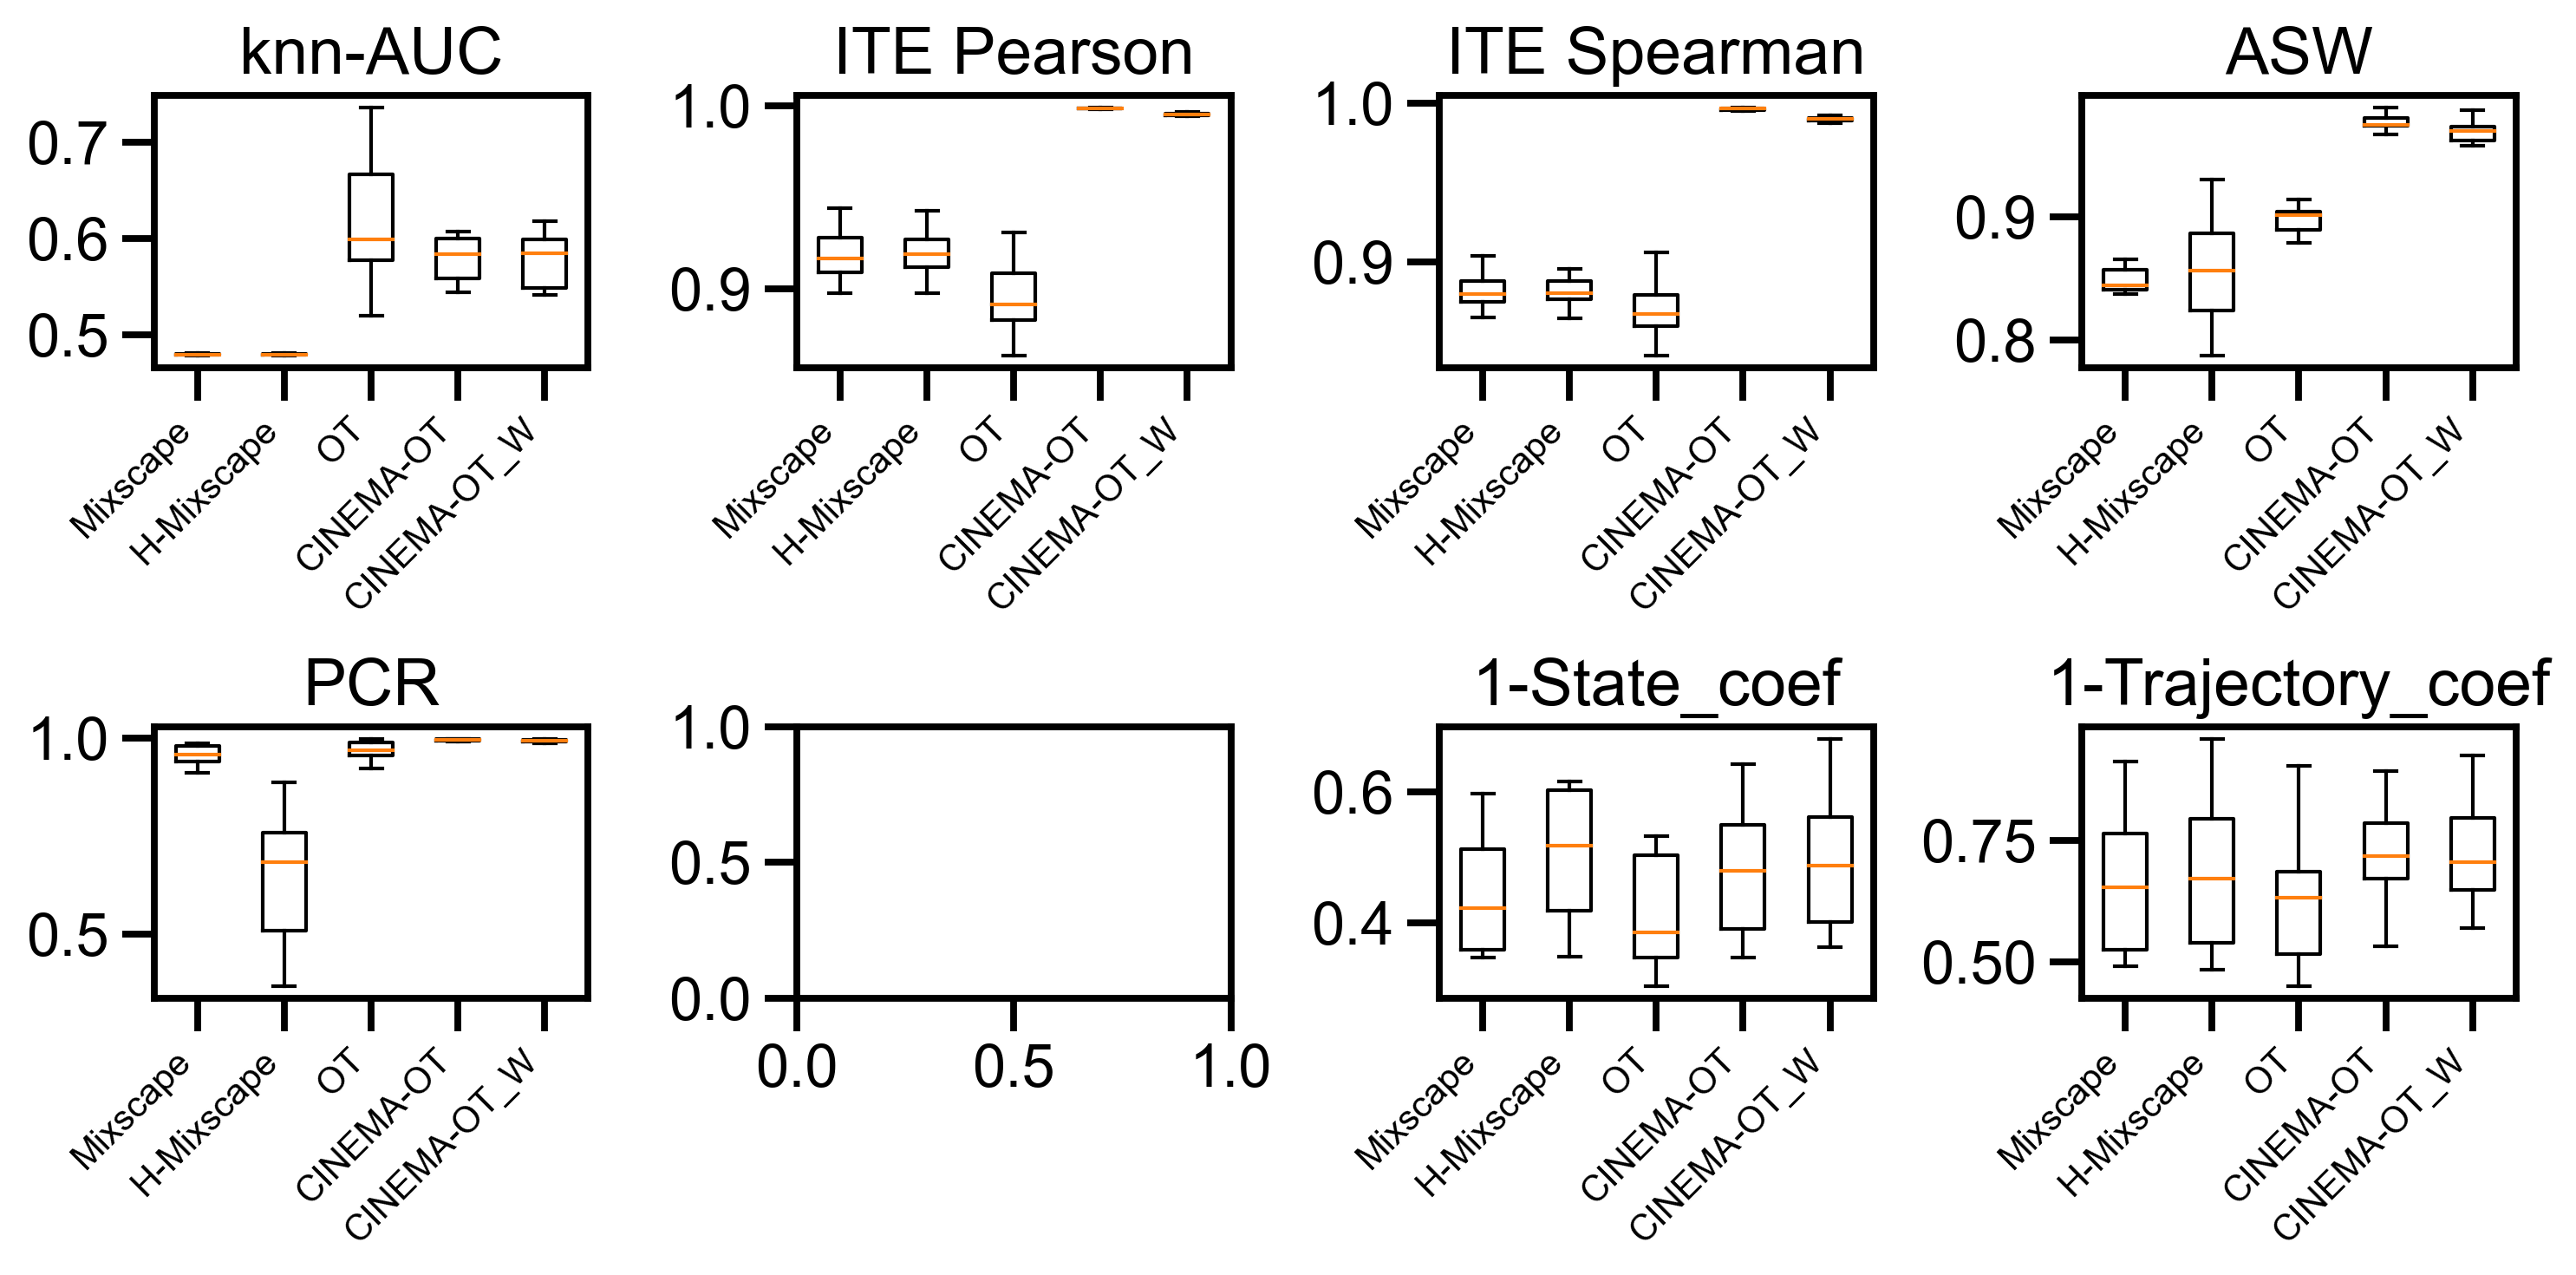

In [12]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = 'Arial'
fig, axs = plt.subplots(2,4, figsize=(10, 5))
axs[0,0].boxplot([auc_mixscape,auc_harmony,auc_OT,auc_cinemaot,auc_wcinemaot],showfliers=False)
axs[0,0].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[0,0].set_title('knn-AUC')
axs[0,1].boxplot([corr_mixscape,corr_harmony,corr_OT,corr_cinemaot,corr_wcinemaot],showfliers=False)
axs[0,1].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[0,1].set_title('ITE Pearson')

axs[0,2].boxplot([scorr_mixscape,scorr_harmony,scorr_OT,scorr_cinemaot,scorr_wcinemaot],showfliers=False)
axs[0,2].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[0,2].set_title('ITE Spearman')

axs[0,3].boxplot([metrics_mixscape.iloc[3,:].values,metrics_harmony.iloc[3,:].values,metrics_OT.iloc[3,:].values,metrics_cinemaot.iloc[3,:].values,metrics_wcinemaot.iloc[3,:].values],showfliers=False)
axs[0,3].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[0,3].set_title('ASW')
axs[1,0].boxplot([metrics_mixscape.iloc[4,:].values,metrics_harmony.iloc[4,:].values,metrics_OT.iloc[4,:].values,metrics_cinemaot.iloc[4,:].values,metrics_wcinemaot.iloc[4,:].values],showfliers=False)
axs[1,0].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[1,0].set_title('PCR')

axs[1,2].boxplot([1-metrics_mixscape.loc['states'].values,1-metrics_harmony.loc['states'].values,1-metrics_OT.loc['states'].values,1-metrics_cinemaot.loc['states'].values,1-metrics_wcinemaot.loc['states'].values],showfliers=False)
axs[1,2].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[1,2].set_title('1-State_coef')
axs[1,3].boxplot([1-metrics_mixscape.loc['steps'].values,1-metrics_harmony.loc['steps'].values,1-metrics_OT.loc['steps'].values,1-metrics_cinemaot.loc['steps'].values,1-metrics_wcinemaot.loc['steps'].values],showfliers=False)
axs[1,3].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[1,3].set_title('1-Trajectory_coef')
fig.tight_layout()

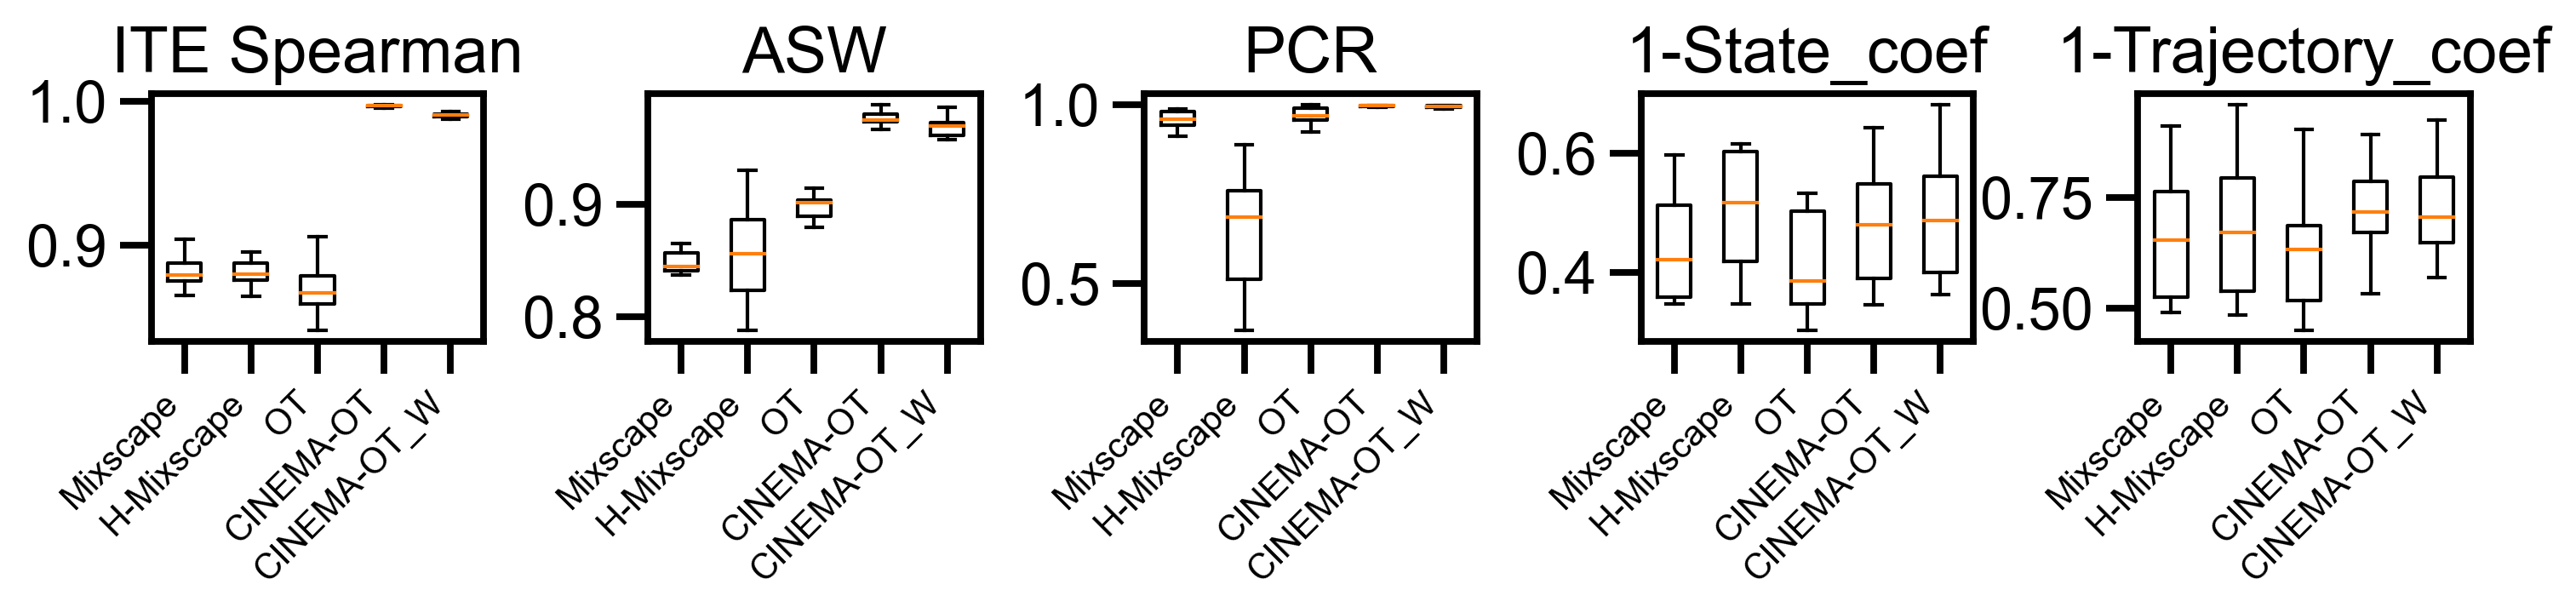

In [13]:

fig, axs = plt.subplots(1,5, figsize=(10, 2.5))

axs[0].boxplot([scorr_mixscape,scorr_harmony,scorr_OT,scorr_cinemaot,scorr_wcinemaot],showfliers=False)
axs[0].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[0].set_title('ITE Spearman')
axs[1].boxplot([metrics_mixscape.iloc[3,:].values,metrics_harmony.iloc[3,:].values,metrics_OT.iloc[3,:].values,metrics_cinemaot.iloc[3,:].values,metrics_wcinemaot.iloc[3,:].values],showfliers=False)
axs[1].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[1].set_title('ASW')
axs[2].boxplot([metrics_mixscape.iloc[4,:].values,metrics_harmony.iloc[4,:].values,metrics_OT.iloc[4,:].values,metrics_cinemaot.iloc[4,:].values,metrics_wcinemaot.iloc[4,:].values],showfliers=False)
axs[2].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[2].set_title('PCR')
axs[3].boxplot([1-metrics_mixscape.loc['states'].values,1-metrics_harmony.loc['states'].values,1-metrics_OT.loc['states'].values,1-metrics_cinemaot.loc['states'].values,1-metrics_wcinemaot.loc['states'].values],showfliers=False)
axs[3].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[3].set_title('1-State_coef')
axs[4].boxplot([1-metrics_mixscape.loc['steps'].values,1-metrics_harmony.loc['steps'].values,1-metrics_OT.loc['steps'].values,1-metrics_cinemaot.loc['steps'].values,1-metrics_wcinemaot.loc['steps'].values],showfliers=False)
axs[4].set_xticklabels(['Mixscape','H-Mixscape','OT','CINEMA-OT','CINEMA-OT_W'],fontsize=10,rotation=45, ha='right')
axs[4].set_title('1-Trajectory_coef')
fig.tight_layout()